In [16]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import nibabel as nib

from tensorflow import keras
from tensorflow.keras import layers

from scipy import ndimage

In [32]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    #print(volume.shape)
    return volume


In [33]:
scan_paths = [
    os.path.join(os.getcwd(), "../BET_BSE_DATA", x)
    for x in os.listdir("../BET_BSE_DATA")
]

print("Brain scans: " + str(len(scan_paths)))

Brain scans: 4


In [34]:
import csv
 
# csv file name
filename = "/home/joelkik/DataMining/BET_BSE_DATA/Label_file.csv"
 
# initializing the titles and rows list
fields = []
labels_dict = dict()
 
# reading csv file
with open(filename, 'r') as csvfile:
    # creating a csv reader object
    csvreader = csv.reader(csvfile)
     
    # extracting field names through first row
    fields = next(csvreader)
 
    # extracting each data row one by one
    for row in csvreader:
        #print(row)
        if row[1].lower() == 'yes':
            labels_dict[row[0]+'.gz'] = 1
        else:
            labels_dict[row[0]+'.gz'] = 0
 
    # get total number of rows
    print("Total no. of rows: %d"%(csvreader.line_num))
 
# printing the field names
print('Field names are:' + ', '.join(field for field in fields))
#print(labels_dict)

Total no. of rows: 1312
Field names are:Filename, Recognizable-Facial-Feature, Brain-Feature-Loss


In [35]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [36]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
brain_scans=[]
labels_facial_feature=[]
labels_to_file=[]
for path in os.listdir("/home/joelkik/DataMining/BET_BSE_DATA/files"):
    brain_scans.append(process_scan("/home/joelkik/DataMining/BET_BSE_DATA/files/"+path))
    labels_facial_feature.append(labels_dict[path])
    labels_to_file.append(path)
    if len(brain_scans)>6 and len(labels_facial_feature)>2:
        break
        
    

(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)


In [37]:
brain_scans_np = np.array(brain_scans)
labels_facial_feature_np = np.array(labels_facial_feature)

In [38]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(brain_scans, labels_facial_feature, test_size=0.20, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=42)


In [39]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

<unknown>


Dimension of the CT scan is: (128, 128, 64, 1)
(128, 128, 1)


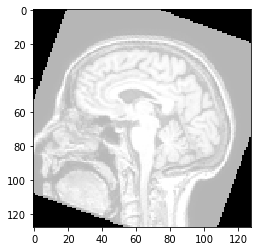

In [81]:
import matplotlib.pyplot as plt

data = train_dataset.take(6)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
#print("labels", labels, data)
print("Dimension of the CT scan is:", image.shape)
print(image[:, :, 30].shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
#plt.imshow(np.squeeze(image[:, :, 20]), cmap="gray")

In [41]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_8 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_9 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [42]:
model.load_weights("/home/joelkik/DataMining/CPSC8650_Project/3d_brain_image_classification.h5")

In [43]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_brain_image_classification.h5", save_best_only=True, monitor='val_acc'
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=5)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
2/2 [==============================] - 30s 15s/step - loss: 0.1955 - acc: 1.0000 - val_loss: 0.0154 - val_acc: 1.0000
Epoch 2/100


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [16]:
model.load_weights("/home/joelkik/DataMining/CPSC8650_Project/3d_brain_image_classification.h5")

In [36]:

for i in range(20):
    prediction = model.predict(np.expand_dims(brain_scans_np[i], axis=0))[0]
    print("Scan File: ", labels_to_file[i], ", Actual: ", labels_facial_feature_np[i], ", Predicted: ",round(float(prediction)))


Scan File:  IXI476-IOP-1140-T1_bse_less_s47_r1.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI048-HH-1326-T1_bse_less_s44_r1.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI554-Guys-1068-T1_bet_18.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI115-Guys-0738-T1_bse_high_s76_r2.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI156-Guys-0837-T1_bse_less_s42_r1.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI218-HH-1815-T1_bse_high_s74_r2.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI038-Guys-0729-T1_bet_85.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI464-IOP-1029-T1_bse_default.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI435-IOP-1040-T1_bet_82.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI350-Guys-0908-T1_bet_82.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI013-HH-1212-T1_bet_19.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI607-Guys-1097-T1_bse_less_s56_r1.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI350-Guys-0908-T1_bet_1.nii.gz , Act